#Import Libraries

In [71]:
#common libraries
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt 

#preprocessing
from sklearn.feature_extraction.text import CountVectorizer   
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import TfidfTransformer 
from sklearn.model_selection import train_test_split, RandomizedSearchCV

#machine learning classification models
from sklearn.svm import LinearSVC
from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import MultinomialNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression

#machine learning model evaluation
from sklearn import metrics
from sklearn.metrics import classification_report, confusion_matrix, f1_score, precision_score, recall_score

#ignore warnings
import warnings
warnings.filterwarnings('ignore')

#Get the data

In [72]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [73]:
pd.set_option('display.max_colwidth', None)

In [74]:
path = "/content/drive/MyDrive/FYP Code/Data/EDA Dataset (Symbols & Emojis).csv"
df = pd.read_csv(path)

In [75]:
df.columns

Index(['Unnamed: 0', 'location', 'search_term', 'text', 'date', 'text_len',
       'word_count', 'polarity', 'subjectivity', 'sentiment',
       'remstopwords_text', 'tokenized', 'lemmatize_text', 'stemmed_text'],
      dtype='object')

#Check percentage of duplicated tweets

In [76]:
dupPercentage = round((1-(df['text'].nunique()/len(df['text'])))*100,2)
print('Percentage of duplicated tweets:')
print(dupPercentage, '%')

Percentage of duplicated tweets:
0.02 %


In [77]:
duplicate = df[df.duplicated('text')]
duplicate

,Unnamed: 0,location,search_term,text,date,text_len,word_count,polarity,subjectivity,sentiment,remstopwords_text,tokenized,lemmatize_text,stemmed_text
5597,5598,"Malmö, Sweden",#marinelitter,join the regional conference of and the programme focused on and in the virtual participation is available on april learn more and register at,3/23/22 12:00 AM,143,24,0.45,0.45,Positive,join regional conference programme focused virtual participation available april learn register,"['join', 'the', 'regional', 'conference', 'of', 'and', 'the', 'programme', 'focused', 'on', 'and', 'in', 'the', 'virtual', 'participation', 'is', 'available', 'on', 'april', 'learn', 'more', 'and', 'register', 'at']",join regional conference programme focused virtual participation available april learn register,"['join', 'region', 'confer', 'programm', 'focus', 'virtual', 'particip', 'avail', 'april', 'learn', 'regist']"


#Building Classification Models

A pipeline consists of vectorization and model fitting will be employed to build the classification models. This pipeline will vectorize the text data before fitting it to the respective models.

The 5 models listed below will be considered:
*   Naive Bayes
*   Random Forest
*   K-Nearest Neighbors (KNN)
*   Logistic Regression
*   Linear Support Vector Classifier (SVC)

##Split train data into features and target variables

In [78]:
df['sentiment'] = df['sentiment'].map({'Positive': 1, 'Negative': -1, 'Neutral': 0})

In [79]:
# Split the dataset into train & validation (25%) for model training - to evaluate model performance and get the best model

# Seperate features (X) and tagret variables (y)
#features = ["text","text_len", "word_count", "polarity", "subjectivity"]
#X = df[features]
X = df['text']
y = df['sentiment']

# Split the train data to create validation dataset
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.20, random_state=1)

In [80]:
print("Input Training:",X_train.shape)
print("Input Test:",X_valid.shape)
print("Output Training:",y_train.shape)
print("Output Test:",y_valid.shape)

Input Training: (4994,)
Input Test: (1249,)
Output Training: (4994,)
Output Test: (1249,)


##Build custom pipeline for each model

In [81]:
#Naïve Bayes
nb = Pipeline([('tfidf', TfidfVectorizer()),
               ('clf', MultinomialNB())])

#Random Forest Classifier
rf = Pipeline([('tfidf', TfidfVectorizer()),
               ('clf', RandomForestClassifier(max_depth=5, 
                                              n_estimators=100))])

#K-Nearest Neighbors Classifier
knn = Pipeline([('tfidf', TfidfVectorizer()),
                ('clf', KNeighborsClassifier(n_neighbors=5, 
                                             metric='minkowski', 
                                             p=2))])

#Logistic Regression
lr = Pipeline([('tfidf',TfidfVectorizer()),
               ('clf',LogisticRegression(C=1, 
                                         class_weight='balanced', 
                                         max_iter=1000))])
#Linear Support Vector Classifier
lsvc = Pipeline([('tfidf', TfidfVectorizer()),
                 ('clf', LinearSVC(class_weight='balanced'))])

##Training Models

The models are trained by passing the train data through each custom pipeline which is then used to predict the classes for the validation dataset.

In [82]:
#Naïve Bayes
nb.fit(X_train, y_train)
y_pred_nb = nb.predict(X_valid)

#Random Forest 
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_valid)

#K-Nearest Neighbors
knn.fit(X_train, y_train)
y_pred_knn = knn.predict(X_valid)

#Linear Regression
lr.fit(X_train, y_train)
y_pred_lr = lr.predict(X_valid)

#Linear Support Vector Classifier
lsvc.fit(X_train, y_train)
y_pred_lsvc = lsvc.predict(X_valid)

##Model Evaluation

The performance of each model will be evaluated based on the precision, accuracy and F1 score achieved when the model is used to predict the classes for the validation dataset. The metrics will be visualize and determine using classification report, confusion matrix and the best model will be selected based on the weighted F1 score.

###Random Forest

              precision    recall  f1-score   support

          -1       0.00      0.00      0.00       247
           0       0.00      0.00      0.00       314
           1       0.55      1.00      0.71       688

    accuracy                           0.55      1249
   macro avg       0.18      0.33      0.24      1249
weighted avg       0.30      0.55      0.39      1249



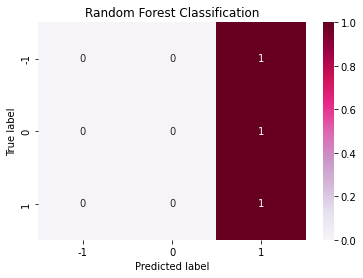

In [83]:
#generate a classification report
print(metrics.classification_report(y_valid, y_pred_rf))

#generate a normalized confusion matrix
cm = confusion_matrix(y_valid, y_pred_rf)
cm_norm = cm / cm.sum(axis=1).reshape(-1,1)

#display the confusion matrix as a heatmap
sns.heatmap(cm_norm, 
            cmap="PuRd", 
            xticklabels=rf.classes_, 
            yticklabels=rf.classes_, 
            vmin=0., 
            vmax=1., 
            annot=True, 
            annot_kws={'size':10})

#adding headings and lables
plt.title('Random Forest Classification')
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

###Naïve Bayes

              precision    recall  f1-score   support

          -1       1.00      0.02      0.05       247
           0       1.00      0.07      0.13       314
           1       0.56      1.00      0.72       688

    accuracy                           0.57      1249
   macro avg       0.85      0.36      0.30      1249
weighted avg       0.76      0.57      0.44      1249



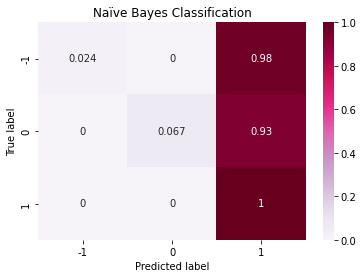

In [84]:
#generate a classification report
print(metrics.classification_report(y_valid, y_pred_nb))

#generate a normalized confusion matrix
cm = confusion_matrix(y_valid, y_pred_nb)
cm_norm = cm / cm.sum(axis=1).reshape(-1,1)

#display the confusion matrix as a heatmap
sns.heatmap(cm_norm, 
            cmap="PuRd", 
            xticklabels=nb.classes_, 
            yticklabels=nb.classes_, 
            vmin=0., 
            vmax=1., 
            annot=True, 
            annot_kws={'size':10})

#adding headings and lables
plt.title('Naïve Bayes Classification')
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

###K-Nearest Neighbors

              precision    recall  f1-score   support

          -1       0.41      0.36      0.39       247
           0       0.38      0.55      0.45       314
           1       0.68      0.57      0.62       688

    accuracy                           0.52      1249
   macro avg       0.49      0.50      0.49      1249
weighted avg       0.55      0.52      0.53      1249



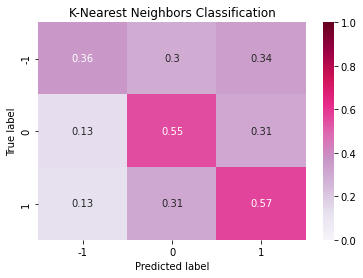

In [85]:
#generate a classification report
print(metrics.classification_report(y_valid, y_pred_knn))

#generate a normalized confusion matrix
cm = confusion_matrix(y_valid, y_pred_knn)
cm_norm = cm / cm.sum(axis=1).reshape(-1,1)

#display the confusion matrix as a heatmap
sns.heatmap(cm_norm, 
            cmap="PuRd", 
            xticklabels=knn.classes_, 
            yticklabels=knn.classes_, 
            vmin=0., 
            vmax=1., 
            annot=True, 
            annot_kws={'size':10})

#addding headings and lables
plt.title('K-Nearest Neighbors Classification')
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

###Logistic Regression

              precision    recall  f1-score   support

          -1       0.60      0.69      0.64       247
           0       0.69      0.71      0.70       314
           1       0.83      0.78      0.80       688

    accuracy                           0.74      1249
   macro avg       0.71      0.73      0.72      1249
weighted avg       0.75      0.74      0.75      1249



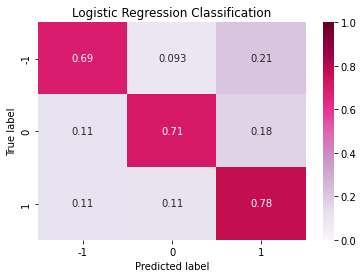

In [86]:
#generate a classification report
print(metrics.classification_report(y_valid, y_pred_lr))

#generate a normalized confusion matrix
cm = confusion_matrix(y_valid, y_pred_lr)
cm_norm = cm / cm.sum(axis=1).reshape(-1,1)

#display the confusion matrix as a heatmap
sns.heatmap(cm_norm, 
            cmap="PuRd", 
            xticklabels=lr.classes_, 
            yticklabels=lr.classes_, 
            vmin=0., 
            vmax=1., 
            annot=True, 
            annot_kws={'size':10})

#adding headings and lables
plt.title('Logistic Regression Classification')
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

###Linear SVC

              precision    recall  f1-score   support

          -1       0.70      0.62      0.66       247
           0       0.73      0.71      0.72       314
           1       0.81      0.86      0.84       688

    accuracy                           0.77      1249
   macro avg       0.75      0.73      0.74      1249
weighted avg       0.77      0.77      0.77      1249



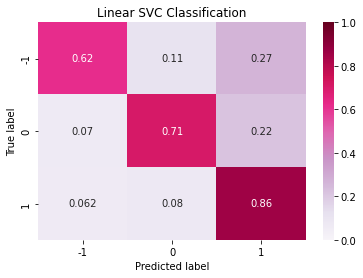

In [87]:
#generate a classification report
print(metrics.classification_report(y_valid, y_pred_lsvc))

#generate a normalized confusion matrix
cm = confusion_matrix(y_valid, y_pred_lsvc)
cm_norm = cm / cm.sum(axis=1).reshape(-1,1)

#display the confusion matrix as a heatmap
sns.heatmap(cm_norm, 
            cmap="PuRd", 
            xticklabels=lsvc.classes_, 
            yticklabels=lsvc.classes_, 
            vmin=0., 
            vmax=1., 
            annot=True, 
            annot_kws={'size':10})

#adding headings and lables
plt.title('Linear SVC Classification')
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

##Hyperparameter Tuning

In [88]:
#retrain linear SVC (because it achieves the highest accuracy) using optimal hyperparameters:
lsvc_op = Pipeline([('tfidf', TfidfVectorizer(max_df=0.8,
                                              min_df=2,
                                              ngram_range=(1,2))),
                  ('clf', LinearSVC(C=0.3,
                                    class_weight='balanced',
                                    max_iter=3000))])

#fit and predict
lsvc_op.fit(X_train, y_train)
y_pred = lsvc_op.predict(X_valid)

print('F1 score improved by',
      round(100*((metrics.accuracy_score(y_pred, y_valid) - metrics.accuracy_score(y_pred_lsvc, y_valid)) /metrics.accuracy_score(y_pred_lsvc, y_valid)),0), 
      '%')

F1 score improved by -4.0 %


#Testing

In [89]:
pathTestFile = "/content/drive/MyDrive/FYP Code/Data/TestFile.csv"
test = pd.read_csv(pathTestFile, sep='|', encoding='latin-1')
y_test = lsvc_op.predict(test['text'])
output = pd.DataFrame({'test': test.text,
                       'sentiment': y_test})
output.to_csv('submission.csv', index=False)
output

,test,sentiment
0,floating sensors are used to create a model of the ocean currents in and around the archipelago the project is part of the plastic pollution free galapagos external link collaboration with the galapagos conservation trust and partners via,1
1,this is shocking while is going on this is what west africa is dealing with the fashion waste of the world litterally pouring into and polluting their cities ocean and ecosystems,-1
2,learning about the rainbow fish this week so i thought iÕd jazz it up with a little side topic about pollution in the ocean the kids had huge amounts of fun with fishes jellyfish and turtles plus we got to stick rubbish up on the wall whatÕs not to love __,1
3,concept for op hhu car firevocu ocean pollution and its effect on wildlifeperfu sexy funeral,0
4,mosaic has to remove fluoride from phosphate rock so it boils it in h2so4 the fluoriderich gas has to be collected its pollution otherwise andhuge fines they cant dump it into the ocean lakes or rivers huge fines because its toxic waste so they sell it now a product,1
...,...,...
4271,14 of the worldÕs equivalent to more than all living coral in was lost in 18we must emphasize the prevention of on coasts and declining water quality to improve,1
4272,have one of the highest levels of of any ecosystem on the planet but recent ubc study finds their capacity to provide benefits to the ecosystem has declined by half since the s,1
4273,kills of worldÕs corals in years combined with coastal development and declining quality destroyed ecosystems home to a of all marine and via,1
4274,unsustainable amp reduced water quality are other factors impacting says the data there are clearly unsettling trends toward coral loss amp we can expect these to continue as warming persists said paul hardisty,-1
